# PAI Assignment 3
Student: Georgy Andryushchenko 

For text classification I've chosen to build and train a BiLSTM model using Tensorflow. Since I have a little experience in building such models I used the help of [this tutorial](https://www.tensorflow.org/text/tutorials/text_classification_rnn).

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
# check if gpu is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Data Preparation

In [4]:
# read data from file
df = pd.read_csv('SMSSpamCollection.txt', sep='\t', names=['label', 'text'])
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [5]:
# encode label column
df['label'] = df['label'].astype('category').cat.codes
df

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will ü b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


<AxesSubplot:>

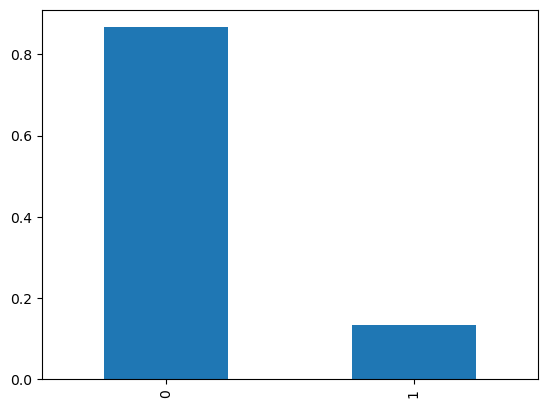

In [7]:
# plot df label values perentage
df['label'].value_counts(normalize=True).plot(kind='bar')

In [8]:
# split data into train and test with 90% and 10% respectively with stratify
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.1, random_state=42, stratify=df['label']
)


In [9]:
# compose tensorflow dataset from train and test data
train_ds = tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
test_ds = tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))

In [10]:
# create batches
BATCH_SIZE = 15

# train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Building Model

The model has the following architecture. It takes the sentence, maps indices from the encoder vocabulary to the words, and produces trainable embedding vector for each input word. The embedding vectors are processed by bidirectional LSTM layer. Fully connected(Dense) layer does classification afterwards.

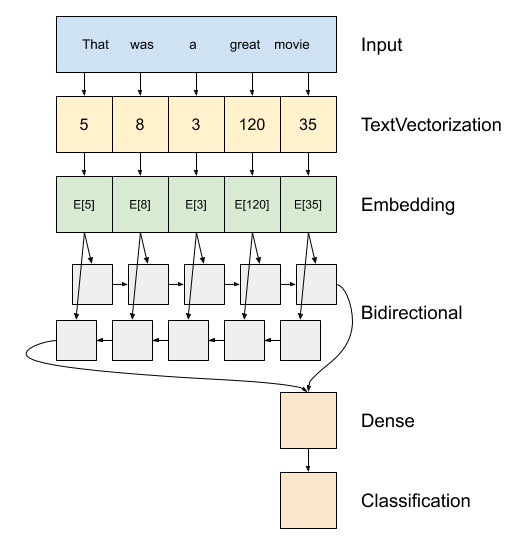

In [11]:
# create encoder
VOCAB_SIZE = 1000

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
# encoder.adapt(train_dataset.map(lambda text, label: text))
encoder.adapt(train_ds.map(lambda text, label: text))

In [12]:
len(encoder.get_vocabulary())

1000

In [13]:
encoder

In [52]:
# compose model architecture
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True # enable to handle variable sequence lengths
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [53]:
# provide loss, optimizer, and metric
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

### Training

In [54]:
# train the model with 10 epochs
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
    validation_steps=30
)

Epoch 1/10
335/335 [==============================] - 14s 28ms/step - loss: 0.5011 - accuracy: 0.8660 - val_loss: 0.2972 - val_accuracy: 0.8578
Epoch 2/10
335/335 [==============================] - 8s 22ms/step - loss: 0.1323 - accuracy: 0.9503 - val_loss: 0.1178 - val_accuracy: 0.9644
Epoch 3/10
335/335 [==============================] - 7s 22ms/step - loss: 0.0685 - accuracy: 0.9805 - val_loss: 0.0959 - val_accuracy: 0.9711
Epoch 4/10
335/335 [==============================] - 7s 21ms/step - loss: 0.0515 - accuracy: 0.9852 - val_loss: 0.0900 - val_accuracy: 0.9756
Epoch 5/10
335/335 [==============================] - 7s 21ms/step - loss: 0.0395 - accuracy: 0.9894 - val_loss: 0.0885 - val_accuracy: 0.9756
Epoch 6/10
335/335 [==============================] - 7s 20ms/step - loss: 0.0307 - accuracy: 0.9908 - val_loss: 0.0898 - val_accuracy: 0.9778
Epoch 7/10
335/335 [==============================] - 7s 19ms/step - loss: 0.0239 - accuracy: 0.9928 - val_loss: 0.0961 - val_accuracy: 0.975

### Testing

In [55]:
# predict the labels for testing dataset
predictions = model.predict(test_ds)

# make binary predictions
predictions = np.where(predictions > 0, 1, 0)

# show classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

38/38 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       483
           1       0.97      0.92      0.95        75

    accuracy                           0.99       558
   macro avg       0.98      0.96      0.97       558
weighted avg       0.99      0.99      0.99       558



It's reasonable to use such model since it shows F1 score to be pretty high

In [42]:
# show predictions for the first testing batch
print('Prediction(isSpam?) - Text')
print("======================================")
for example, label in test_ds.take(1):
    texts = example.numpy()
    predictions = model.predict(np.array(texts)) >= 0
    for i in range(len(texts)):
        print(predictions[i, 0], '-', texts[i])

Prediction(isSpam?) - Text
1/1 [==============================] - 2s 2s/step
False - b'Or better still can you catch her and let ask her if she can sell  &lt;#&gt;  for me.'
True - b"Loan for any purpose \xc2\xa3500 - \xc2\xa375,000. Homeowners + Tenants welcome. Have you been previously refused? We can still help. Call Free 0800 1956669 or text back 'help'"
False - b'Every day i use to sleep after  &lt;#&gt;  so only.'
False - b"Unless it's a situation where YOU GO GURL would be more appropriate"
True - b'No. 1 Nokia Tone 4 ur mob every week! Just txt NOK to 87021. 1st Tone FREE ! so get txtin now and tell ur friends. 150p/tone. 16 reply HL 4info'
False - b'Dunno lei shd b driving lor cos i go sch 1 hr oni.'
False - b'Wat would u like 4 ur birthday?'
False - b'Dunno leh cant remember mayb lor. So wat time r we meeting tmr?'
False - b"Just haven't decided where yet eh ?"
False - b'Remember to ask alex about his pizza'
False - b'Ok lor...'
False - b'Good! No, don\xe2\x80\x98t need any r

### Decision Boundary Visualization

The model takes the text as input and assigns `word_id`s to each word. That's how the model converts input to vectors. The dimensionality of this vectors is much higher than 2, so it's difficult to visualize the decision boundary. But we try to reduce dimensionality with PCA. 

In [94]:
# assign ids to words and compose vectors
def vectorize_text(text):
    return model.layers[0](text)

In [100]:
# get predictions from the input vectors
def predict_from_vector(vector):
    res = vector
    for i in range(1, len(model.layers)):
        res = model.layers[i](res)
    # binary res
    return np.where(res > 0, 1, 0)

In [118]:
# compute vectors from the testing text
vectors = vectorize_text(X_test.to_numpy())
vectors

<tf.Tensor: shape=(558, 95), dtype=int64, numpy=
array([[ 28, 306,  94, ...,   0,   0,   0],
       [  1,  13,  99, ...,   0,   0,   0],
       [178,  66,   3, ...,   0,   0,   0],
       ...,
       [339,  71,   2, ...,   0,   0,   0],
       [ 34,   4,  85, ...,   0,   0,   0],
       [  3, 200,   4, ...,   0,   0,   0]], dtype=int64)>

In [119]:
# get predictions for the testing text
predictions = predict_from_vector(vectors)
predictions.shape

(558, 1)

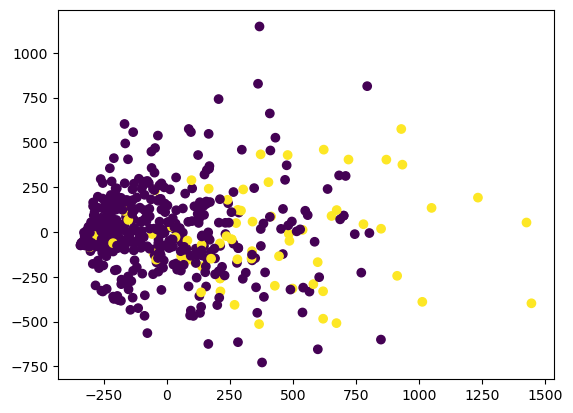

In [126]:
# reduce dimensionality of vectors with pca
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(vectors)
vectors = pca.transform(vectors)

# plot vectors
plt.scatter(vectors[:, 0], vectors[:, 1], c=predictions)


As you may see, it's difficult the separate the samples with a line or a curve at this dimensionality. But we may notice that the samples to the right tend to be classified as 1, but it's not always the case. Anyway, let's try to separate the samples with a line

In [172]:
# import linear svc
from sklearn.svm import LinearSVC

clf = LinearSVC(loss="hinge", random_state=42).fit(vectors, predictions.ravel())

c:\Users\datapaf\miniconda3\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


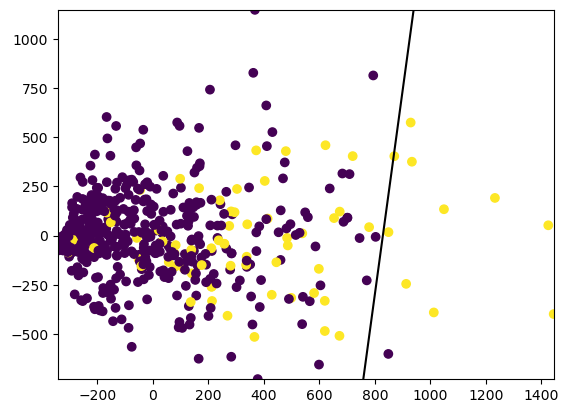

In [180]:
from sklearn.inspection import DecisionBoundaryDisplay

ax = plt.gca()
DecisionBoundaryDisplay.from_estimator(
        clf,
        vectors,
        ax=ax,
        grid_resolution=50,
        plot_method="contour",
        colors="k",
        levels=[0],
    )
plt.scatter(vectors[:, 0], vectors[:, 1], c=predictions)

Decision boundary is almost vertical, so it supports the assumption that samples to the right tend to be spam